# !pip install neurokit2

In [4]:
!nvidia-smi

Mon Jul 25 10:10:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   35C    P0    38W / 300W |      2MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [6]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse


In [7]:
from helper_code import *
from get_feature import *
from utils.models import *
import sys
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import datetime
import tensorflow as tf
from sklearn.impute import SimpleImputer
from tqdm import tqdm

In [8]:
root_dir = '/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3'
training_data_file = root_dir +'/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

In [9]:
df = pd.read_csv(training_data_file)
df[:10]

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.90,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.10,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.10,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.90,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.20,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
6,23625,AV+PV+TV+MV,Child,Female,92.0,14.00,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,50379.0
7,24160,AV+PV+TV+MV,Child,Female,98.0,17.66,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
8,29045,AV+PV+TV+MV,Child,Female,88.0,12.50,False,Present,AV+MV+PV+TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
9,29378,AV+MV,Child,Female,82.0,10.70,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


In [10]:
data_folder =  training_data_dir

In [11]:
patient_files = find_patient_files(data_folder)
num_patient_files = len(patient_files)
num_patient_files

942

In [12]:
train_data_folder = '/home/ubuntu/hmd/sy_classifier/notebooks_sy/data_split/murmur/train'
test_data_folder = '/home/ubuntu/hmd/sy_classifier/notebooks_sy/data_split/murmur/test'

In [13]:
patient_files_trn = find_patient_files(train_data_folder)
patient_files_test = find_patient_files(test_data_folder)

num_patient_files = len(patient_files_trn)
num_patient_files

751

In [14]:
current_patient_data = load_patient_data(patient_files[1])
current_patient_data

'9979 4 4000\nAV 9979_AV.hea 9979_AV.wav 9979_AV.tsv\nPV 9979_PV.hea 9979_PV.wav 9979_PV.tsv\nTV 9979_TV.hea 9979_TV.wav 9979_TV.tsv\nMV 9979_MV.hea 9979_MV.wav 9979_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 103.0\n#Weight: 13.1\n#Pregnancy status: False\n#Murmur: Present\n#Murmur locations: AV+MV+PV+TV\n#Most audible location: TV\n#Systolic murmur timing: Holosystolic\n#Systolic murmur shape: Diamond\n#Systolic murmur grading: III/VI\n#Systolic murmur pitch: High\n#Systolic murmur quality: Harsh\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Outcome: Abnormal\n#Campaign: CC2015\n#Additional ID: nan\n'

## wav feature confind

In [15]:
fnms = os.listdir(root_dir + '/training_data')

In [16]:
fnms

['index.html',
 '13918.txt',
 '13918_AV.hea',
 '13918_AV.tsv',
 '13918_AV.wav',
 '13918_MV.hea',
 '13918_MV.tsv',
 '13918_MV.wav',
 '13918_PV.hea',
 '13918_PV.tsv',
 '13918_PV.wav',
 '13918_TV.hea',
 '13918_TV.tsv',
 '13918_TV.wav',
 '14241.txt',
 '14241_AV.hea',
 '14241_AV.tsv',
 '14241_AV.wav',
 '14241_MV.hea',
 '14241_MV.tsv',
 '14241_MV.wav',
 '14241_PV.hea',
 '14241_PV.tsv',
 '14241_PV.wav',
 '14241_TV.hea',
 '14241_TV.tsv',
 '14241_TV.wav',
 '14998.txt',
 '14998_AV.hea',
 '14998_AV.tsv',
 '14998_AV.wav',
 '14998_MV.hea',
 '14998_MV.tsv',
 '14998_MV.wav',
 '14998_PV.hea',
 '14998_PV.tsv',
 '14998_PV.wav',
 '14998_TV.hea',
 '14998_TV.tsv',
 '14998_TV.wav',
 '23625.txt',
 '23625_AV.hea',
 '23625_AV.tsv',
 '23625_AV.wav',
 '23625_MV.hea',
 '23625_MV.tsv',
 '23625_MV.wav',
 '23625_PV.hea',
 '23625_PV.tsv',
 '23625_PV.wav',
 '23625_TV.hea',
 '23625_TV.tsv',
 '23625_TV.wav',
 '24160.txt',
 '24160_AV.hea',
 '24160_AV.tsv',
 '24160_AV.wav',
 '24160_MV.hea',
 '24160_MV.tsv',
 '24160_MV.wav

In [17]:
fnms_wav = [a for a in fnms if a.split('.')[1] == 'wav']
fnms_wav

['13918_AV.wav',
 '13918_MV.wav',
 '13918_PV.wav',
 '13918_TV.wav',
 '14241_AV.wav',
 '14241_MV.wav',
 '14241_PV.wav',
 '14241_TV.wav',
 '14998_AV.wav',
 '14998_MV.wav',
 '14998_PV.wav',
 '14998_TV.wav',
 '23625_AV.wav',
 '23625_MV.wav',
 '23625_PV.wav',
 '23625_TV.wav',
 '24160_AV.wav',
 '24160_MV.wav',
 '24160_PV.wav',
 '24160_TV.wav',
 '2530_AV.wav',
 '2530_MV.wav',
 '2530_PV.wav',
 '2530_TV.wav',
 '29045_AV.wav',
 '29045_MV.wav',
 '29045_PV.wav',
 '29045_TV.wav',
 '29378_AV.wav',
 '29378_MV.wav',
 '31737_AV.wav',
 '31737_MV.wav',
 '31737_PV.wav',
 '31737_TV.wav',
 '33151_AV.wav',
 '33151_MV.wav',
 '33151_PV.wav',
 '33151_TV.wav',
 '36327_AV.wav',
 '36327_MV.wav',
 '36327_PV.wav',
 '36327_TV.wav',
 '38337_AV.wav',
 '38337_MV.wav',
 '39043_AV.wav',
 '39043_MV.wav',
 '39043_PV.wav',
 '39043_TV.wav',
 '39403_AV.wav',
 '39403_MV.wav',
 '39403_PV.wav',
 '39403_TV.wav',
 '39456_MV.wav',
 '39456_PV.wav',
 '39456_TV.wav',
 '40058_AV.wav',
 '40058_MV.wav',
 '40058_PV.wav',
 '40058_TV.wav',
 

In [18]:
fname = root_dir + '/training_data/' + fnms_wav[1]
fname

'/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/13918_MV.wav'

In [19]:
!pip install hrv-analysis

In [34]:
!pip install pyhrv

     |████████████████████████████████| 3.2 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 230 kB 88.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 50.6 MB/s eta 0:00:01
     |████████████████████████████████| 60.9 MB 199 kB/s  eta 0:00:01    |███                             | 5.8 MB 52.6 MB/s eta 0:00:02
     |████████████████████████████████| 829 kB 81.7 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 9.1 MB/s  eta 0:00:01
  Created wheel for biosppy: filename=biosppy-0.8.0-py2.py3-none-any.whl size=100155 sha256=aea50187595440fe007127b6ba0e4061f1ff5f162420417a975bef7485edd26e
  Stored in directory: /home/ubuntu/.cache/pip/wheels/32/17/9d/77adbf0db713546eaa1c7a1480b2dce91fa724a133115dc20c
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=ae86de0cb4a64963936996c0b371e3f7b9ef8c99e34f9870fb2787acf7e7d360
  Stored in directory: /home/ubuntu/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b

In [20]:
patient_data = load_patient_data(patient_files[1])
patient_data

'9979 4 4000\nAV 9979_AV.hea 9979_AV.wav 9979_AV.tsv\nPV 9979_PV.hea 9979_PV.wav 9979_PV.tsv\nTV 9979_TV.hea 9979_TV.wav 9979_TV.tsv\nMV 9979_MV.hea 9979_MV.wav 9979_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 103.0\n#Weight: 13.1\n#Pregnancy status: False\n#Murmur: Present\n#Murmur locations: AV+MV+PV+TV\n#Most audible location: TV\n#Systolic murmur timing: Holosystolic\n#Systolic murmur shape: Diamond\n#Systolic murmur grading: III/VI\n#Systolic murmur pitch: High\n#Systolic murmur quality: Harsh\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Outcome: Abnormal\n#Campaign: CC2015\n#Additional ID: nan\n'

In [21]:
recordings = load_recordings(data_folder, patient_data)
recordings

[array([1653, 3815, 3101, ...,  187,  348,   53], dtype=int16),
 array([32596, 28290,  8851, ...,  6449,  6299,  7167], dtype=int16),
 array([   244,  -3588, -22579, ...,   -207,   -205,   -204], dtype=int16),
 array([5039, 5952, 5754, ...,  344,  229,   87], dtype=int16)]

In [22]:
        current_patient_data = load_patient_data(patient_files_trn[1])
        num_locations = get_num_locations(current_patient_data)
        
        recording_information = current_patient_data.split('\n')[1:num_locations+1]

In [23]:
recording_information

['AV 9979_AV.hea 9979_AV.wav 9979_AV.tsv',
 'PV 9979_PV.hea 9979_PV.wav 9979_PV.tsv',
 'TV 9979_TV.hea 9979_TV.wav 9979_TV.tsv',
 'MV 9979_MV.hea 9979_MV.wav 9979_MV.tsv']

In [24]:
        for j in range(num_locations) :
            entries = recording_information[j].split(' ')
            recording_file = entries[2]

In [25]:
recording_file

'9979_MV.wav'

In [26]:
    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    num_patient_files = len(patient_files_trn)

    for i in tqdm.tqdm(range(num_patient_files)):

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files_trn[i])
        num_locations = get_num_locations(current_patient_data)
        recording_information = current_patient_data.split('\n')[1:num_locations+1]
        for j in range(num_locations) :
            entries = recording_information[j].split(' ')
            recording_file = entries[2]

AttributeError: type object 'tqdm' has no attribute 'tqdm'

In [27]:
filename = os.path.join(data_folder, recording_file)
filename

'/home/ubuntu/hmd/notebooks/physionet.org/files/circor-heart-sound/1.0.3/training_data/9979_MV.wav'

In [28]:
____, recording1 = sp.io.wavfile.read(filename)

In [29]:
recording1

array([5039, 5952, 5754, ...,  344,  229,   87], dtype=int16)

In [58]:
len(recordings)

4

In [30]:
recordings[1]

array([32596, 28290,  8851, ...,  6449,  6299,  7167], dtype=int16)

In [31]:
ecg_signals, info  = nk.ecg_process(recordings[1], sampling_rate=4000)

In [32]:
np.diff(info['ECG_R_Peaks'])/4000

array([0.8495 , 0.50725, 0.6445 , 0.792  , 0.61775, 0.6455 , 0.61375,
       0.65275, 0.60375, 0.628  , 0.60375, 0.50325, 0.633  , 0.7495 ,
       0.633  , 0.6185 , 0.6185 , 0.613  , 0.45175, 0.79575, 0.654  ,
       0.60625, 0.50525, 0.773  , 0.452  , 0.82775, 0.62225, 0.53075,
       0.744  ])

In [166]:
info['ECG_R_Peaks']/4000

array([ 0.72375,  1.57325,  2.0805 ,  2.725  ,  3.517  ,  4.13475,
        4.78025,  5.394  ,  6.04675,  6.6505 ,  7.2785 ,  7.88225,
        8.3855 ,  9.0185 ,  9.768  , 10.401  , 11.0195 , 11.638  ,
       12.251  , 12.70275, 13.4985 , 14.1525 , 14.75875, 15.264  ,
       16.037  , 16.489  , 17.31675, 17.939  , 18.46975, 19.21375])

In [129]:
diff_sig_2 = np.diff(info['ECG_R_Peaks'])
diff_sig_2

array([3398, 2029, 2578, 3168, 2471, 2582, 2455, 2611, 2415, 2512, 2415,
       2013, 2532, 2998, 2532, 2474, 2474, 2452, 1807, 3183, 2616, 2425,
       2021, 3092, 1808, 3311, 2489, 2123, 2976])

In [130]:
diff_sig_2 = np.diff(info['ECG_R_Peaks']/4000)
diff_sig_2

array([0.8495 , 0.50725, 0.6445 , 0.792  , 0.61775, 0.6455 , 0.61375,
       0.65275, 0.60375, 0.628  , 0.60375, 0.50325, 0.633  , 0.7495 ,
       0.633  , 0.6185 , 0.6185 , 0.613  , 0.45175, 0.79575, 0.654  ,
       0.60625, 0.50525, 0.773  , 0.452  , 0.82775, 0.62225, 0.53075,
       0.744  ])

In [131]:
rr = np.mean(np.diff(info['ECG_R_Peaks'])/4000)

In [132]:
rr

0.6375862068965518

In [64]:
info['ECG_R_Peaks']

array([ 2895,  6293,  8322, 10900, 14068, 16539, 19121, 21576, 24187,
       26602, 29114, 31529, 33542, 36074, 39072, 41604, 44078, 46552,
       49004, 50811, 53994, 56610, 59035, 61056, 64148, 65956, 69267,
       71756, 73879, 76855])

## welch diagram - PPG signal

In [67]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
rr_intervals_list = info['ECG_R_Peaks']

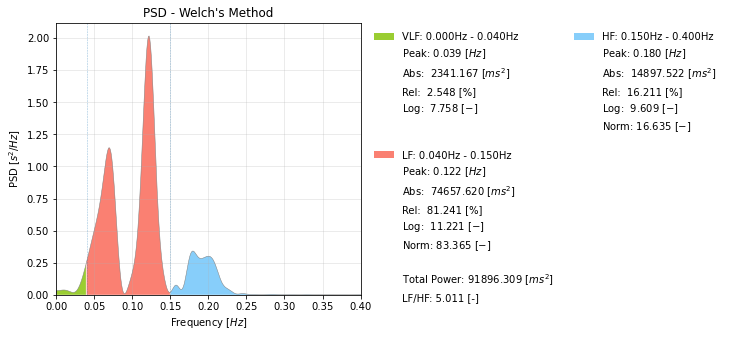

(0.0390625, 0.1220703125, 0.1796875)


In [68]:
import pyhrv.frequency_domain as fd
import pyhrv.tools as tools
nni = tools.nn_intervals(rr_intervals_list)
result = fd.welch_psd(nni=nni)
# Access peak frequencies using the key 'fft_peak'
print(result['fft_peak'])

## QRS

In [33]:
sys.path.insert(0, '/home/ubuntu/hmd/sy_classifier/notebooks_sy/QRS-detection')
sys.path.insert(0, '/home/ubuntu/hmd/sy_classifier/notebooks_sy/QRS-detection/data')

In [34]:
import os
import sys
from util.QRS_util import*

In [35]:
import os
import sys
from util.QRS_util import*

'''
QRS detection demo 
@author: Kemeng Chen: kemengchen@email.arizona.edu
'''

def QRS_test(file_name):
	'''
	QRS detection on file_name
	assuming 360 Hz sampling rate, may not work with very low sampling rate signal
	args:
		file_name: file containing ecg data in one column
	'''
# 	fs=360
	fs=4000
	file_path=os.path.join(os.getcwd(), 'data', file_name)
	if not os.path.isfile(file_path):
		raise AssertionError(file_path, 'not exists')
	ecg=read_ecg(file_path)
	R_peaks, S_pint, Q_point=EKG_QRS_detect(ecg, fs, False, True)

# if __name__ == '__main__':
# 	if len(sys.argv)<2:
# 		raise ValueError('No file name specified')
# 	QRS_test(sys.argv[1])

In [36]:
recordings

[array([1653, 3815, 3101, ...,  187,  348,   53], dtype=int16),
 array([32596, 28290,  8851, ...,  6449,  6299,  7167], dtype=int16),
 array([   244,  -3588, -22579, ...,   -207,   -205,   -204], dtype=int16),
 array([5039, 5952, 5754, ...,  344,  229,   87], dtype=int16)]

In [37]:
def EKG_QRS_detect1(ecg, fs, QS, plot=False):
	sig_lgth=ecg.shape[0]
	ecg=ecg-np.mean(ecg)
	ecg_lgth_transform=lgth_transform(ecg, int(fs/222))
	# ecg_lgth_transform=lgth_transform(ecg_lgth_transform, int(fs/40))

	ws=int(fs/89)
	ecg_integrate=integrate(ecg_lgth_transform, ws)/ws
	ws=int(fs/67)
	ecg_integrate=integrate(ecg_integrate, ws)
	ws=int(fs/400)
	ecg_integrate=integrate(ecg_integrate, ws)
	ws=int(fs/800)
	ecg_integrate=integrate(ecg_integrate, ws)

	peaks=find_peak(ecg_integrate, int(fs/111))
	R_peaks=find_R_peaks(ecg, peaks, int(fs/444))
	if QS:
		S_point=find_S_point(ecg, R_peaks)
		Q_point=find_Q_point(ecg, R_peaks)
	else:
		S_point=None
		Q_point=None
	if plot:
		index=np.arange(sig_lgth)/fs
		fig, ax=plt.subplots()
		ax.plot(index, ecg, 'b', label='EKG')
		ax.plot(R_peaks/fs, ecg[R_peaks], 'ro', label='R peaks')
		if QS:
			ax.plot(S_point/fs, ecg[S_point], 'go', label='S')
			ax.plot(Q_point/fs, ecg[Q_point], 'yo', label='Q')
		ax.set_xlim([0, sig_lgth/fs])
		ax.set_xlabel('Time [sec]')
		ax.legend()
		# ax[1].plot(ecg_integrate)
		# ax[1].set_xlim([0, ecg_integrate.shape[0]])
		# ax[2].plot(ecg_lgth_transform)
		# ax[2].set_xlim([0, ecg_lgth_transform.shape[0]])
		plt.figure(figsize=(20,45))
		plt.show()
	return R_peaks, S_point, Q_point

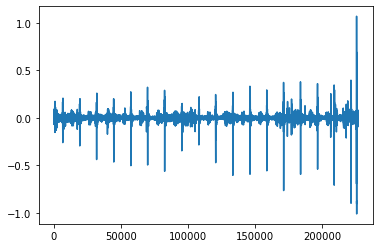

In [38]:
import librosa
import matplotlib.pyplot as plt


fname = root_dir + '/training_data/' + fnms_wav[0]

wav, label = librosa.load(fname)
plt.plot(wav)

In [ ]:
R_peaks, S_pint, Q_point=EKG_QRS_detect(recording1, 4000, True, True)

예제 코드는 fs = 360으로 설정된 코드임. 따라서 우리 코드는 sr = 4000으로 수정해서 사용해야함. 수정한 코드는 EKG_QRS_detect1 함수임!!!

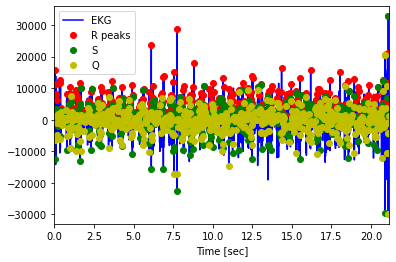

<Figure size 1440x3240 with 0 Axes>

In [40]:
R_peaks, S_pint, Q_point=EKG_QRS_detect1(recording1, 4000, True, True)

In [46]:
features = dict()
features['qrs1'] = []

In [47]:
features

{'qrs1': []}

In [41]:
use_qrs = True

In [51]:
            if use_qrs :
                ____, recording1 = sp.io.wavfile.read(filename)
                R_peaks, S_point, Q_point=EKG_QRS_detect1(recording1, 4000, True, False)
                qrs = np.mean(S_point-Q_point)
            else :
                qrs = np.zeros((1))

In [52]:
qrs

array([0.])

In [53]:
features['qrs1'].append(qrs)  

In [54]:
features

{'qrs1': [12.219063545150501, array([0.])]}

In [50]:
use_qrs = False

In [43]:
len(Q_point)

598

In [169]:
S_pint[1]

280

In [170]:
Q_point[1]

276

In [171]:
S_pint[1]-Q_point[1]

4

In [174]:
np.mean((S_pint-Q_point))

12.219063545150501

In [163]:
R_peaks

array([   93,   279,   409,   558,   687,   820,   940,  1151,  1280,
        1523,  1616,  1687,  1905,  2024,  2127,  2249,  2354,  2473,
        2689,  2837,  2916,  3014,  3153,  3453,  3580,  3690,  3872,
        3970,  4061,  4224,  4319,  4463,  4651,  4747,  4877,  4974,
        5048,  5347,  5530,  5604,  5832,  5990,  6194,  6368,  6466,
        6556,  6702,  6791,  6871,  7044,  7146,  7212,  7314,  7452,
        7706,  7834,  7927,  8013,  8184,  8401,  8470,  8525,  8649,
        8794,  8929,  9015,  9117,  9235,  9497,  9585,  9740,  9912,
       10033, 10168, 10243, 10343, 10403, 10498, 10640, 10787, 10866,
       10941, 11028, 11157, 11230, 11331, 11408, 11563, 11632, 11724,
       11825, 11913, 12065, 12160, 12300, 12426, 12582, 12758, 12869,
       12938, 13152, 13292, 13411, 13491, 13626, 13692, 13818, 14205,
       14322, 14514, 14597, 14774, 14863, 14954, 15086, 15236, 15337,
       15425, 15615, 15777, 15851, 15962, 16049, 16137, 16351, 16541,
       16701, 16813,

In [164]:
S_pint

array([   97,   280,   411,   562,   689,   823,   944,  1152,  1294,
        1535,  1618,  1690,  1905,  2024,  2128,  2250,  2357,  2475,
        2690,  2839,  2918,  3016,  3170,  3460,  3580,  3690,  3872,
        3982,  4064,  4244,  4321,  4465,  4652,  4758,  4880,  4974,
        5050,  5349,  5550,  5616,  5845,  6012,  6197,  6369,  6481,
        6560,  6702,  6795,  6875,  7046,  7148,  7217,  7319,  7460,
        7706,  7840,  7929,  8017,  8188,  8401,  8478,  8530,  8660,
        8807,  8929,  9018,  9117,  9250,  9497,  9587,  9741,  9915,
       10036, 10173, 10245, 10343, 10412, 10499, 10642, 10791, 10870,
       10944, 11044, 11169, 11231, 11339, 11417, 11563, 11636, 11728,
       11838, 11916, 12076, 12162, 12301, 12430, 12583, 12767, 12872,
       12941, 13152, 13295, 13413, 13494, 13633, 13698, 13828, 14206,
       14337, 14524, 14602, 14774, 14864, 14958, 15088, 15236, 15343,
       15438, 15622, 15780, 15851, 15963, 16051, 16142, 16362, 16541,
       16701, 16828,

In [175]:
Q_point

array([   91,   276,   407,   556,   675,   818,   939,  1147,  1268,
        1514,  1613,  1686,  1904,  2013,  2121,  2246,  2350,  2468,
        2688,  2835,  2914,  3006,  3140,  3441,  3579,  3676,  3867,
        3957,  4035,  4220,  4317,  4454,  4646,  4738,  4870,  4962,
        5045,  5345,  5500,  5587,  5819,  5982,  6184,  6361,  6453,
        6532,  6681,  6787,  6868,  7042,  7143,  7210,  7308,  7445,
        7700,  7830,  7925,  8010,  8180,  8399,  8463,  8520,  8632,
        8792,  8926,  9002,  9114,  9226,  9488,  9556,  9736,  9910,
       10021, 10156, 10232, 10339, 10395, 10496, 10637, 10783, 10857,
       10939, 11019, 11151, 11228, 11316, 11402, 11551, 11630, 11719,
       11815, 11910, 12057, 12157, 12297, 12420, 12580, 12757, 12854,
       12933, 13150, 13290, 13410, 13487, 13607, 13676, 13816, 14197,
       14317, 14499, 14591, 14766, 14861, 14948, 15085, 15233, 15324,
       15412, 15615, 15775, 15848, 15958, 16044, 16134, 16349, 16530,
       16683, 16800,

정국오빠는 RR-interval 변수 추가함
그렇다면 나는 다른 의료관련 feature도 추가해서 성능 높여보기